In [1]:
import os
import requests

def save_and_cache(url, path, force=False):
    if not os.path.exists(path) or force:
        print(f"Downloading {url} to {path} ...")
        r = requests.get(url)
        with open(path, 'wb') as f:
            f.write(r.content)

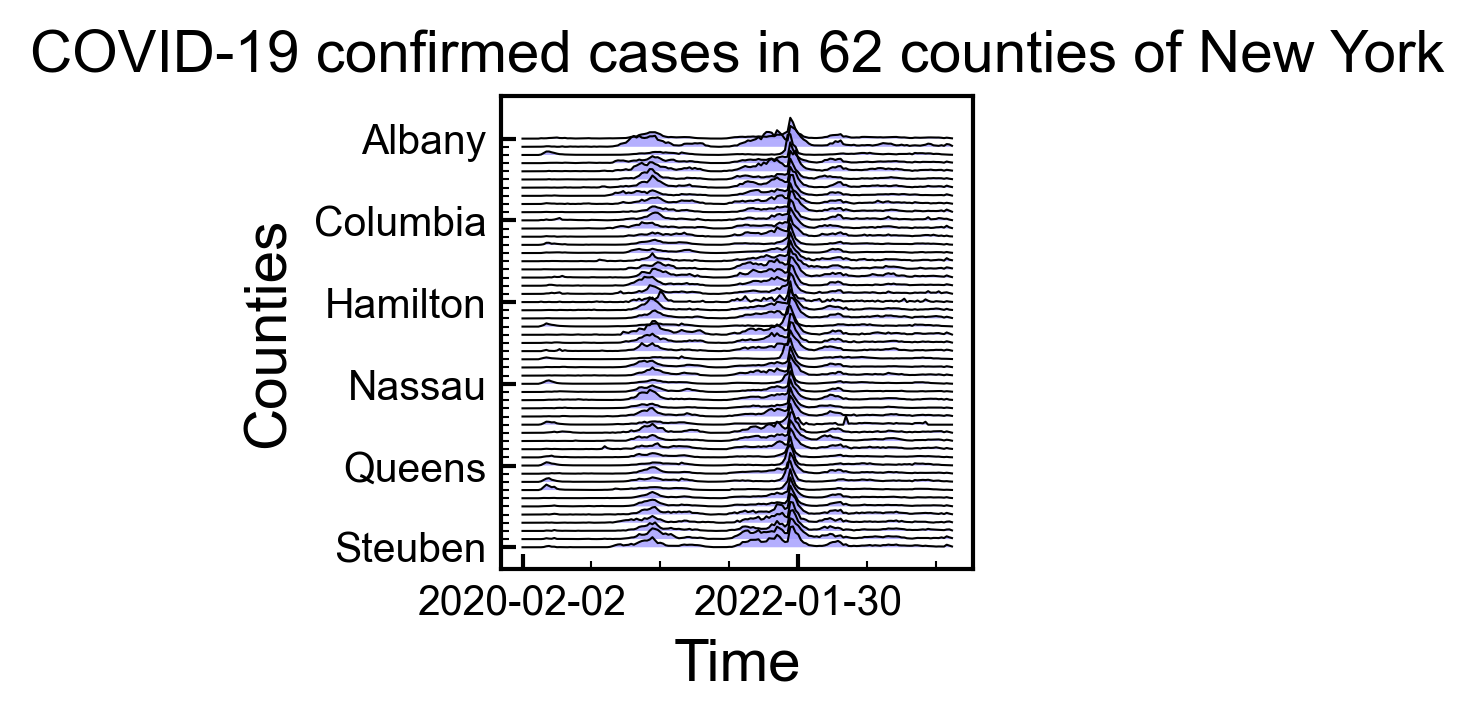

(62,) (163,) (163, 62)


In [2]:
import numpy as np
import pandas as pd

save_and_cache('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv', '../data/epidemic/time_series_covid19_confirmed_US.csv')
df_US = pd.read_csv('../data/epidemic/time_series_covid19_confirmed_US.csv')
df_NY = df_US[df_US['Province_State'] == 'New York'].copy()
df_NY = df_NY[df_NY['Admin2'] != 'Unassigned']
df_NY = df_NY[df_NY['Admin2'] != 'Out of NY']
df_NY.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], inplace=True)
assert len(df_NY['Admin2'].unique()) == len(df_NY['Admin2'])
df_NY.set_index('Admin2', inplace=True)
df_NY.rename(index={'New York': 'Manhattan'}, inplace=True)
df_NY.sort_index(inplace=True)

# 等间隔为 1 日
assert len(pd.to_datetime(df_NY.columns.values, format='%m/%d/%y').diff()[1:].unique()) == 1
# 汇总为 1 周的数据
df_NY.columns = pd.to_datetime(df_NY.columns, format='%m/%d/%y')
df_NY = df_NY.T.resample('W').max().T # 这里是累计确诊数，所以取最大值作为本周累计确诊数

node = df_NY.index.to_numpy() # (N,)
time = pd.to_datetime(df_NY.columns.values, format='%m/%d/%y').astype(str).values[1:] # (T,)
case = np.diff(df_NY.values.T, axis=0) # (T, N)

import matplotlib.pyplot as plt
from ND2.utils import get_fig, clear_svg
fi, fig, axes = get_fig(1, 1, AW=4, AH=4, lw=1.0, fontsize=14)

N = 51
dN = 10
dT = 52 * 2
delta = -1
for idx, name in enumerate(node[:N]):
    scale = N / 20 / case[:, idx].max()
    axes[0].plot(case[:, idx] * scale + delta*idx, color='black', lw=fi.lw/2)
    axes[0].fill_between(np.arange(len(time)), case[:, idx] * scale + delta*idx, delta*idx, color='#a29bfe', alpha=0.8, edgecolor=None)
axes[0].set_xticks(np.arange(len(time))[::dT])
axes[0].set_xticks(np.arange(len(time))[::dT//4], minor=True)
axes[0].set_xticklabels(time[::dT], rotation=0, fontsize=0.7*fi.fontsize)
axes[0].set_xlabel('Time', fontsize=fi.fontsize)

axes[0].set_yticks(delta*np.arange(len(node))[:N:dN])
axes[0].set_yticks(delta*np.arange(len(node))[:N], minor=True)
axes[0].tick_params(axis='both', which='minor', width=fi.lw/2)
axes[0].set_yticklabels(node[:N:dN], fontsize=0.7*fi.fontsize)
# axes[0].set_yticklabels([], fontsize=fi.fontsize)
axes[0].set_ylabel('Counties', fontsize=fi.fontsize)

axes[0].tick_params(axis='both', which='both', direction='in')
axes[0].set_title(f'COVID-19 confirmed cases in {len(node)} counties of New York', fontsize=fi.fontsize)
fig.savefig('../plot/epidemic/COVID19inNYS.png', dpi=300, transparent=True)
fig.savefig('../plot/epidemic/COVID19inNYS.svg', transparent=True)
clear_svg('../plot/epidemic/COVID19inNYS.svg')
plt.show()

print(node.shape, time.shape, case.shape)

In [3]:
node

array(['Albany', 'Allegany', 'Bronx', 'Broome', 'Cattaraugus', 'Cayuga',
       'Chautauqua', 'Chemung', 'Chenango', 'Clinton', 'Columbia',
       'Cortland', 'Delaware', 'Dutchess', 'Erie', 'Essex', 'Franklin',
       'Fulton', 'Genesee', 'Greene', 'Hamilton', 'Herkimer', 'Jefferson',
       'Kings', 'Lewis', 'Livingston', 'Madison', 'Manhattan', 'Monroe',
       'Montgomery', 'Nassau', 'Niagara', 'Oneida', 'Onondaga', 'Ontario',
       'Orange', 'Orleans', 'Oswego', 'Otsego', 'Putnam', 'Queens',
       'Rensselaer', 'Richmond', 'Rockland', 'Saratoga', 'Schenectady',
       'Schoharie', 'Schuyler', 'Seneca', 'St. Lawrence', 'Steuben',
       'Suffolk', 'Sullivan', 'Tioga', 'Tompkins', 'Ulster', 'Warren',
       'Washington', 'Wayne', 'Westchester', 'Wyoming', 'Yates'],
      dtype=object)

In [4]:
len(node)

62

# 移动数据

In [5]:
import gzip
import shutil
import pandas as pd

# see data/cftss-hcbs_kids_fips.xlsx
GEOID2Name = {36001:"Albany", 36003:"Allegany", 36005:"Bronx", 36007:"Broome", 36009:"Cattaraugus", 36011:"Cayuga", 36013:"Chautauqua", 36015:"Chemung", 36017:"Chenango", 36019:"Clinton", 36021:"Columbia", 36023:"Cortland", 36025:"Delaware", 36027:"Dutchess", 36029:"Erie", 36031:"Essex", 36033:"Franklin", 36035:"Fulton", 36037:"Genesee", 36039:"Greene", 36041:"Hamilton", 36043:"Herkimer", 36045:"Jefferson", 36047:"Kings", 36049:"Lewis", 36051:"Livingston", 36053:"Madison", 36055:"Monroe", 36057:"Montgomery", 36059:"Nassau", 36061:"Manhattan", 36063:"Niagara", 36065:"Oneida", 36067:"Onondaga", 36069:"Ontario", 36071:"Orange", 36073:"Orleans", 36075:"Oswego", 36077:"Otsego", 36079:"Putnam", 36081:"Queens", 36083:"Rensselaer", 36085:"Richmond", 36087:"Rockland", 36091:"Saratoga", 36093:"Schenectady", 36095:"Schoharie", 36097:"Schuyler", 36099:"Seneca", 36089:"St. Lawrence", 36101:"Steuben", 36103:"Suffolk", 36105:"Sullivan", 36107:"Tioga", 36109:"Tompkins", 36111:"Ulster", 36113:"Warren", 36115:"Washington", 36117:"Wayne", 36119:"Westchester", 36121:"Wyoming", 36123:"Yates"}

# https://lehd.ces.census.gov/data/ 提供的 OD 数据 (https://lehd.ces.census.gov/data/lodes/LODES8/ny/od/ny_od_main_JT00_2020.csv.gz)，参考 https://lehd.ces.census.gov/data/lodes/LODES8/LODESTechDoc8.1.pdf
save_and_cache('https://lehd.ces.census.gov/data/lodes/LODES8/ny/od/ny_od_main_JT00_2020.csv.gz',
                '../data/epidemic/ny_od_main_JT00_2020.csv.gz')
# if not os.path.exists('../data/epidemic/ny_od_main_JT00_2020.csv'):
#     with gzip.open('../data/epidemic/ny_od_main_JT00_2020.csv.gz', 'rb') as f:
#         shutil.copyfileobj(f, open('../data/epidemic/ny_od_main_JT00_2020.csv', 'wb'))
df = pd.read_csv('../data/epidemic/ny_od_main_JT00_2020.csv.gz', comment='#', compression='gzip')
# 15-digits BLOCK CODE (state(2), county(3), tract(6), block(4)) -> 5-digits COUNTY CODE
df['w_county'] = df['w_geocode'].astype(str).str.slice(0, 5).astype(int).map(GEOID2Name)
df['h_county'] = df['h_geocode'].astype(str).str.slice(0, 5).astype(int).map(GEOID2Name)

df

w_geocode        h_geocode  S000  SA01  SA02  SA03  SE01  SE02  \
0        360010001001003  360359714003008     1     0     1     0     0     0   
1        360010001001004  360010002021006     1     0     1     0     0     1   
2        360010001001004  360010002022011     1     0     1     0     0     0   
3        360010001001004  360010018022000     1     0     1     0     0     0   
4        360010001001004  360010020003001     1     0     1     0     0     1   
...                  ...              ...   ...   ...   ...   ...   ...   ...   
7079288  361231505022059  361231505021041     1     0     1     0     1     0   
7079289  361231505022062  360110402022037     1     1     0     0     1     0   
7079290  361231505022062  361231502003045     1     0     1     0     1     0   
7079291  361231505022062  361231504004021     1     1     0     0     1     0   
7079292  361231505022062  361231505011013     1     0     1     0     1     0   

         SE03  SI01  SI02  SI03  createdate w_county h_county  
0           1     0     0     1    20230321   Albany   Fulton  
1           0     1     0     0    20230321   Albany   Albany  
2           1     1     0     0    20230321   Albany   Albany  
3           1     1     0     0    20230321   Albany   Albany  
4           0     1     0     0    20230321   Albany   Albany  
...       ...   ...   ...   ...         ...      ...      ...  
7079288     0     1     0     0    20230321    Yates    Yates  
7079289     0     0     1     0    20230321    Yates   Cayuga  
7079290     0     0     1     0    20230321    Yates    Yates  
7079291     0     0     1     0    20230321    Yates    Yates  
7079292     0     0     1     0    20230321    Yates    Yates  

[7079293 rows x 15 columns]

In [6]:
df.dropna(subset=['w_county', 'h_county'], inplace=True)
df

w_geocode        h_geocode  S000  SA01  SA02  SA03  SE01  SE02  \
0        360010001001003  360359714003008     1     0     1     0     0     0   
1        360010001001004  360010002021006     1     0     1     0     0     1   
2        360010001001004  360010002022011     1     0     1     0     0     0   
3        360010001001004  360010018022000     1     0     1     0     0     0   
4        360010001001004  360010020003001     1     0     1     0     0     1   
...                  ...              ...   ...   ...   ...   ...   ...   ...   
7079288  361231505022059  361231505021041     1     0     1     0     1     0   
7079289  361231505022062  360110402022037     1     1     0     0     1     0   
7079290  361231505022062  361231502003045     1     0     1     0     1     0   
7079291  361231505022062  361231504004021     1     1     0     0     1     0   
7079292  361231505022062  361231505011013     1     0     1     0     1     0   

         SE03  SI01  SI02  SI03  createdate w_county h_county  
0           1     0     0     1    20230321   Albany   Fulton  
1           0     1     0     0    20230321   Albany   Albany  
2           1     1     0     0    20230321   Albany   Albany  
3           1     1     0     0    20230321   Albany   Albany  
4           0     1     0     0    20230321   Albany   Albany  
...       ...   ...   ...   ...         ...      ...      ...  
7079288     0     1     0     0    20230321    Yates    Yates  
7079289     0     0     1     0    20230321    Yates   Cayuga  
7079290     0     0     1     0    20230321    Yates    Yates  
7079291     0     0     1     0    20230321    Yates    Yates  
7079292     0     0     1     0    20230321    Yates    Yates  

[7079293 rows x 15 columns]

In [7]:
df = df[['w_county', 'h_county', 'S000']]
df.columns = ['source', 'destination', 'flow']
# 汇总
df = df.groupby(['source', 'destination']).sum().reset_index()
# 排除自己到自己的流量
df = df[df['source'] != df['destination']]
# 排除不在 node 中的记录
df = df[df['source'].isin(node) & df['destination'].isin(node)]
assert all(np.sort(df['source'].unique()) == np.sort(df['destination'].unique()))
for i in node: 
    if i not in df['source'].unique():
        print(i)

df

source  destination  flow
1     Albany     Allegany    62
2     Albany        Bronx  1103
3     Albany       Broome  1029
4     Albany  Cattaraugus   110
5     Albany       Cayuga   402
...      ...          ...   ...
3761   Yates       Ulster     1
3762   Yates       Warren     2
3763   Yates   Washington     5
3764   Yates        Wayne   150
3765   Yates      Wyoming    22

[3705 rows x 3 columns]

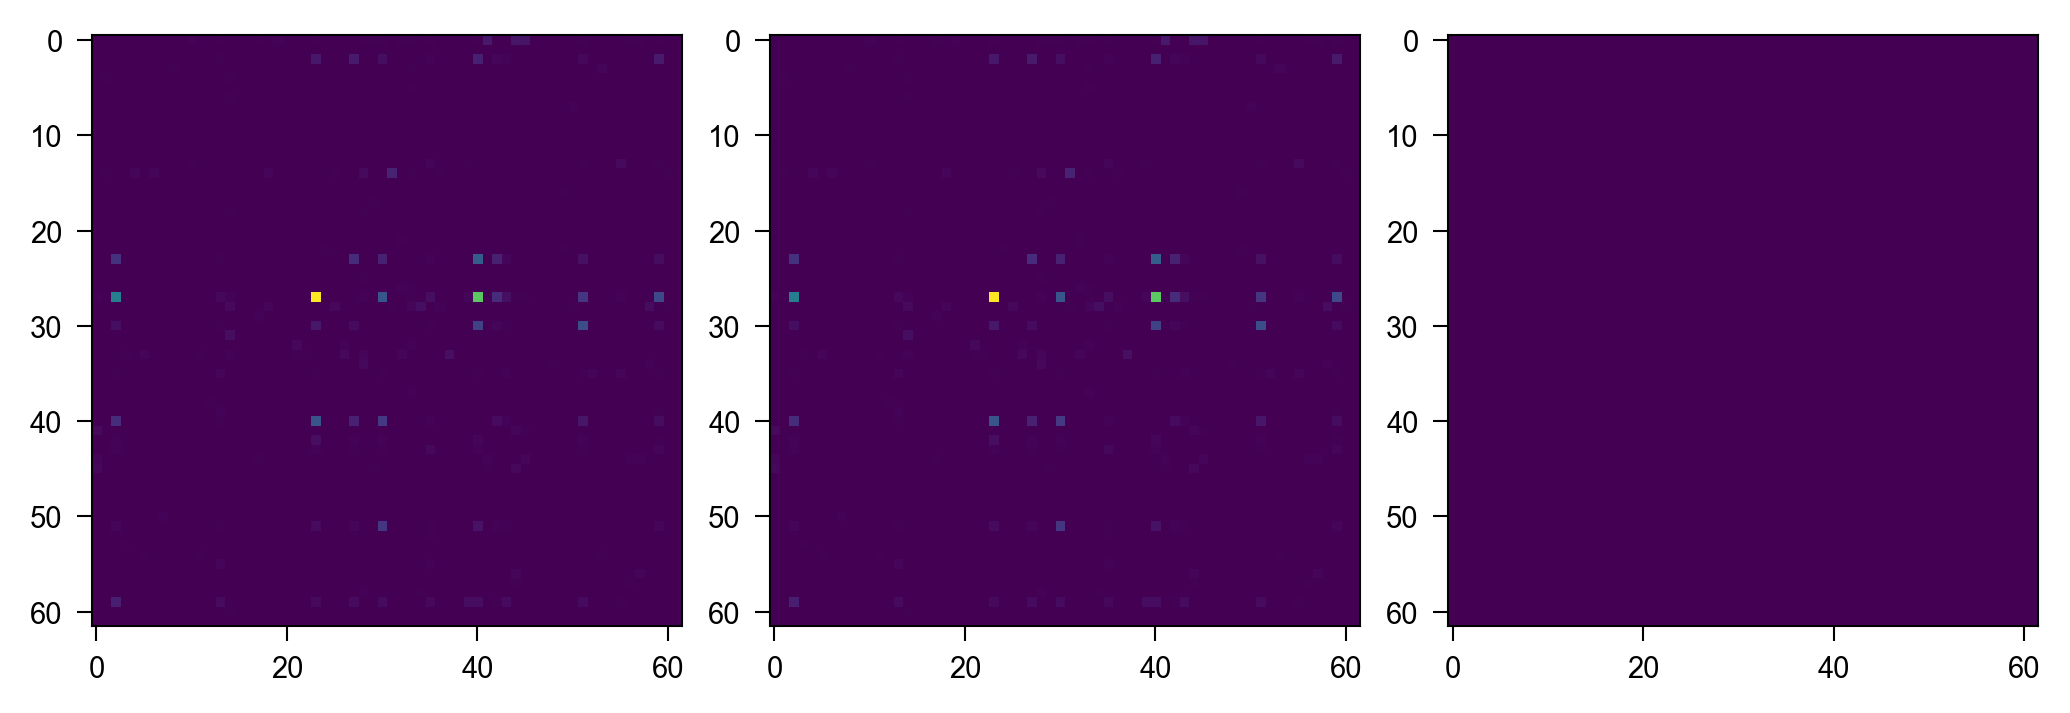

In [8]:
D = 20
df_sparse = df.copy()
df_sparse.sort_values('flow', ascending=False, inplace=True)
df_sparse = df_sparse[:D*len(node)]
df_sparse

from ND2.utils import get_fig
from matplotlib.colors import LogNorm, Normalize
fi, fig, axes = get_fig(1, 3, AW=5)
norm = Normalize(vmin=0, vmax=df['flow'].max())
pivot1 = df.pivot_table(index='source', columns='destination', values='flow', fill_value=0, aggfunc='sum').reindex(index=node, columns=node, fill_value=0)
pivot2 = df_sparse.pivot_table(index='source', columns='destination', values='flow', fill_value=0, aggfunc='sum').reindex(index=node, columns=node, fill_value=0)
axes[0].imshow(pivot1.values, norm=norm)
axes[1].imshow(pivot2.values, norm=norm)
axes[2].imshow(pivot1.values - pivot2.values, norm=norm)
plt.show()

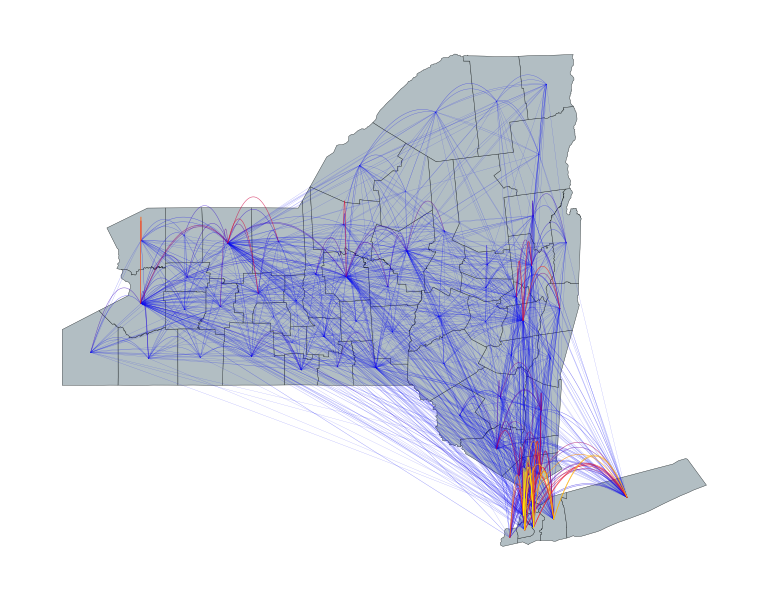

In [9]:
import geopandas as gpd
from ND2.utils.plot import get_fig, plotOD

data = df_sparse
data.columns = ['source', 'destination', 'flow']
# download from https://koordinates.com/layer/96216-new-york-state-counties/
gdf = gpd.read_file('../data/epidemic/kx-new-york-state-counties-SHP.zip')
gdf['NAME'] = gdf['NAME'].replace({'St Lawrence': 'St. Lawrence', 'New York': 'Manhattan'})

fi, fig, axes = get_fig(1, 1, AW=3*2, A_ratio=1, LM=0, RM=0, BM=0, TM=0.0, lw=1.0, fontsize=14)
gdf.plot(ax=axes[0], color='#b2bec3', edgecolor='#2d3436', linewidth=0.1)
location = {row['NAME']: row['geometry'].centroid.coords[0] for _, row in gdf.iterrows()}
plotOD(axes[0], data['source'], data['destination'], data['flow'], location, linetype='parabola')
axes[0].axis('off')
fig.savefig('../plot/epidemic/ODinNYS.png', dpi=600, transparent=True)
fig.savefig('../plot/epidemic/ODinNYS.svg', transparent=True)

Drawing OD Flow:   6%|▌         | 70/1240 [00:00<00:01, 600.60it/s]

Manhattan Kings
Manhattan Queens
Manhattan Bronx
Manhattan Nassau
Manhattan Westchester
Manhattan Suffolk
Manhattan Richmond
Kings Manhattan
Queens Manhattan
Bronx Manhattan
Manhattan Rockland
Manhattan Orange
Westchester Manhattan
Nassau Manhattan
Manhattan Dutchess
Suffolk Manhattan
Manhattan Putnam
Manhattan Ulster
Manhattan Erie
Richmond Manhattan
Manhattan Albany
Manhattan Monroe
Manhattan Onondaga
Rockland Manhattan


Drawing OD Flow:  35%|███▌      | 435/1240 [00:00<00:00, 1107.47it/s]

Manhattan Saratoga
Manhattan Schenectady
Manhattan Rensselaer
Manhattan Sullivan
Manhattan Oneida
Orange Manhattan
Dutchess Manhattan
Albany Manhattan
Manhattan Broome
Manhattan Columbia
Manhattan Niagara
Manhattan Greene
Manhattan Oswego
Manhattan Tompkins


Drawing OD Flow:  54%|█████▍    | 670/1240 [00:00<00:00, 1145.42it/s]

Onondaga Manhattan
Monroe Manhattan
Manhattan Otsego
Manhattan Ontario
Erie Manhattan
Manhattan Cayuga
Manhattan Warren
Manhattan Delaware
Manhattan Madison
Manhattan Wayne
Ulster Manhattan
Manhattan Washington
Manhattan Herkimer
Saratoga Manhattan
Manhattan Fulton
Manhattan Tioga
Manhattan Chautauqua
Manhattan Montgomery
Manhattan Cortland


Drawing OD Flow:  74%|███████▍  | 915/1240 [00:00<00:00, 1181.34it/s]

Manhattan Livingston
Manhattan Genesee
Sullivan Manhattan
Manhattan Jefferson
Manhattan St. Lawrence
Manhattan Chenango
Manhattan Steuben
Warren Manhattan
Manhattan Schoharie
Manhattan Seneca
Manhattan Chemung
Broome Manhattan
Oneida Manhattan
Rensselaer Manhattan
Manhattan Orleans
Manhattan Wyoming


Drawing OD Flow:  93%|█████████▎| 1153/1240 [00:01<00:00, 996.24it/s]

Manhattan Clinton
Manhattan Cattaraugus
Putnam Manhattan
Tompkins Manhattan
Columbia Manhattan
Manhattan Franklin
Schenectady Manhattan
Manhattan Allegany


Drawing MODZCTA Boundaries: 100%|██████████| 62/62 [00:00<00:00, 476.93it/s]


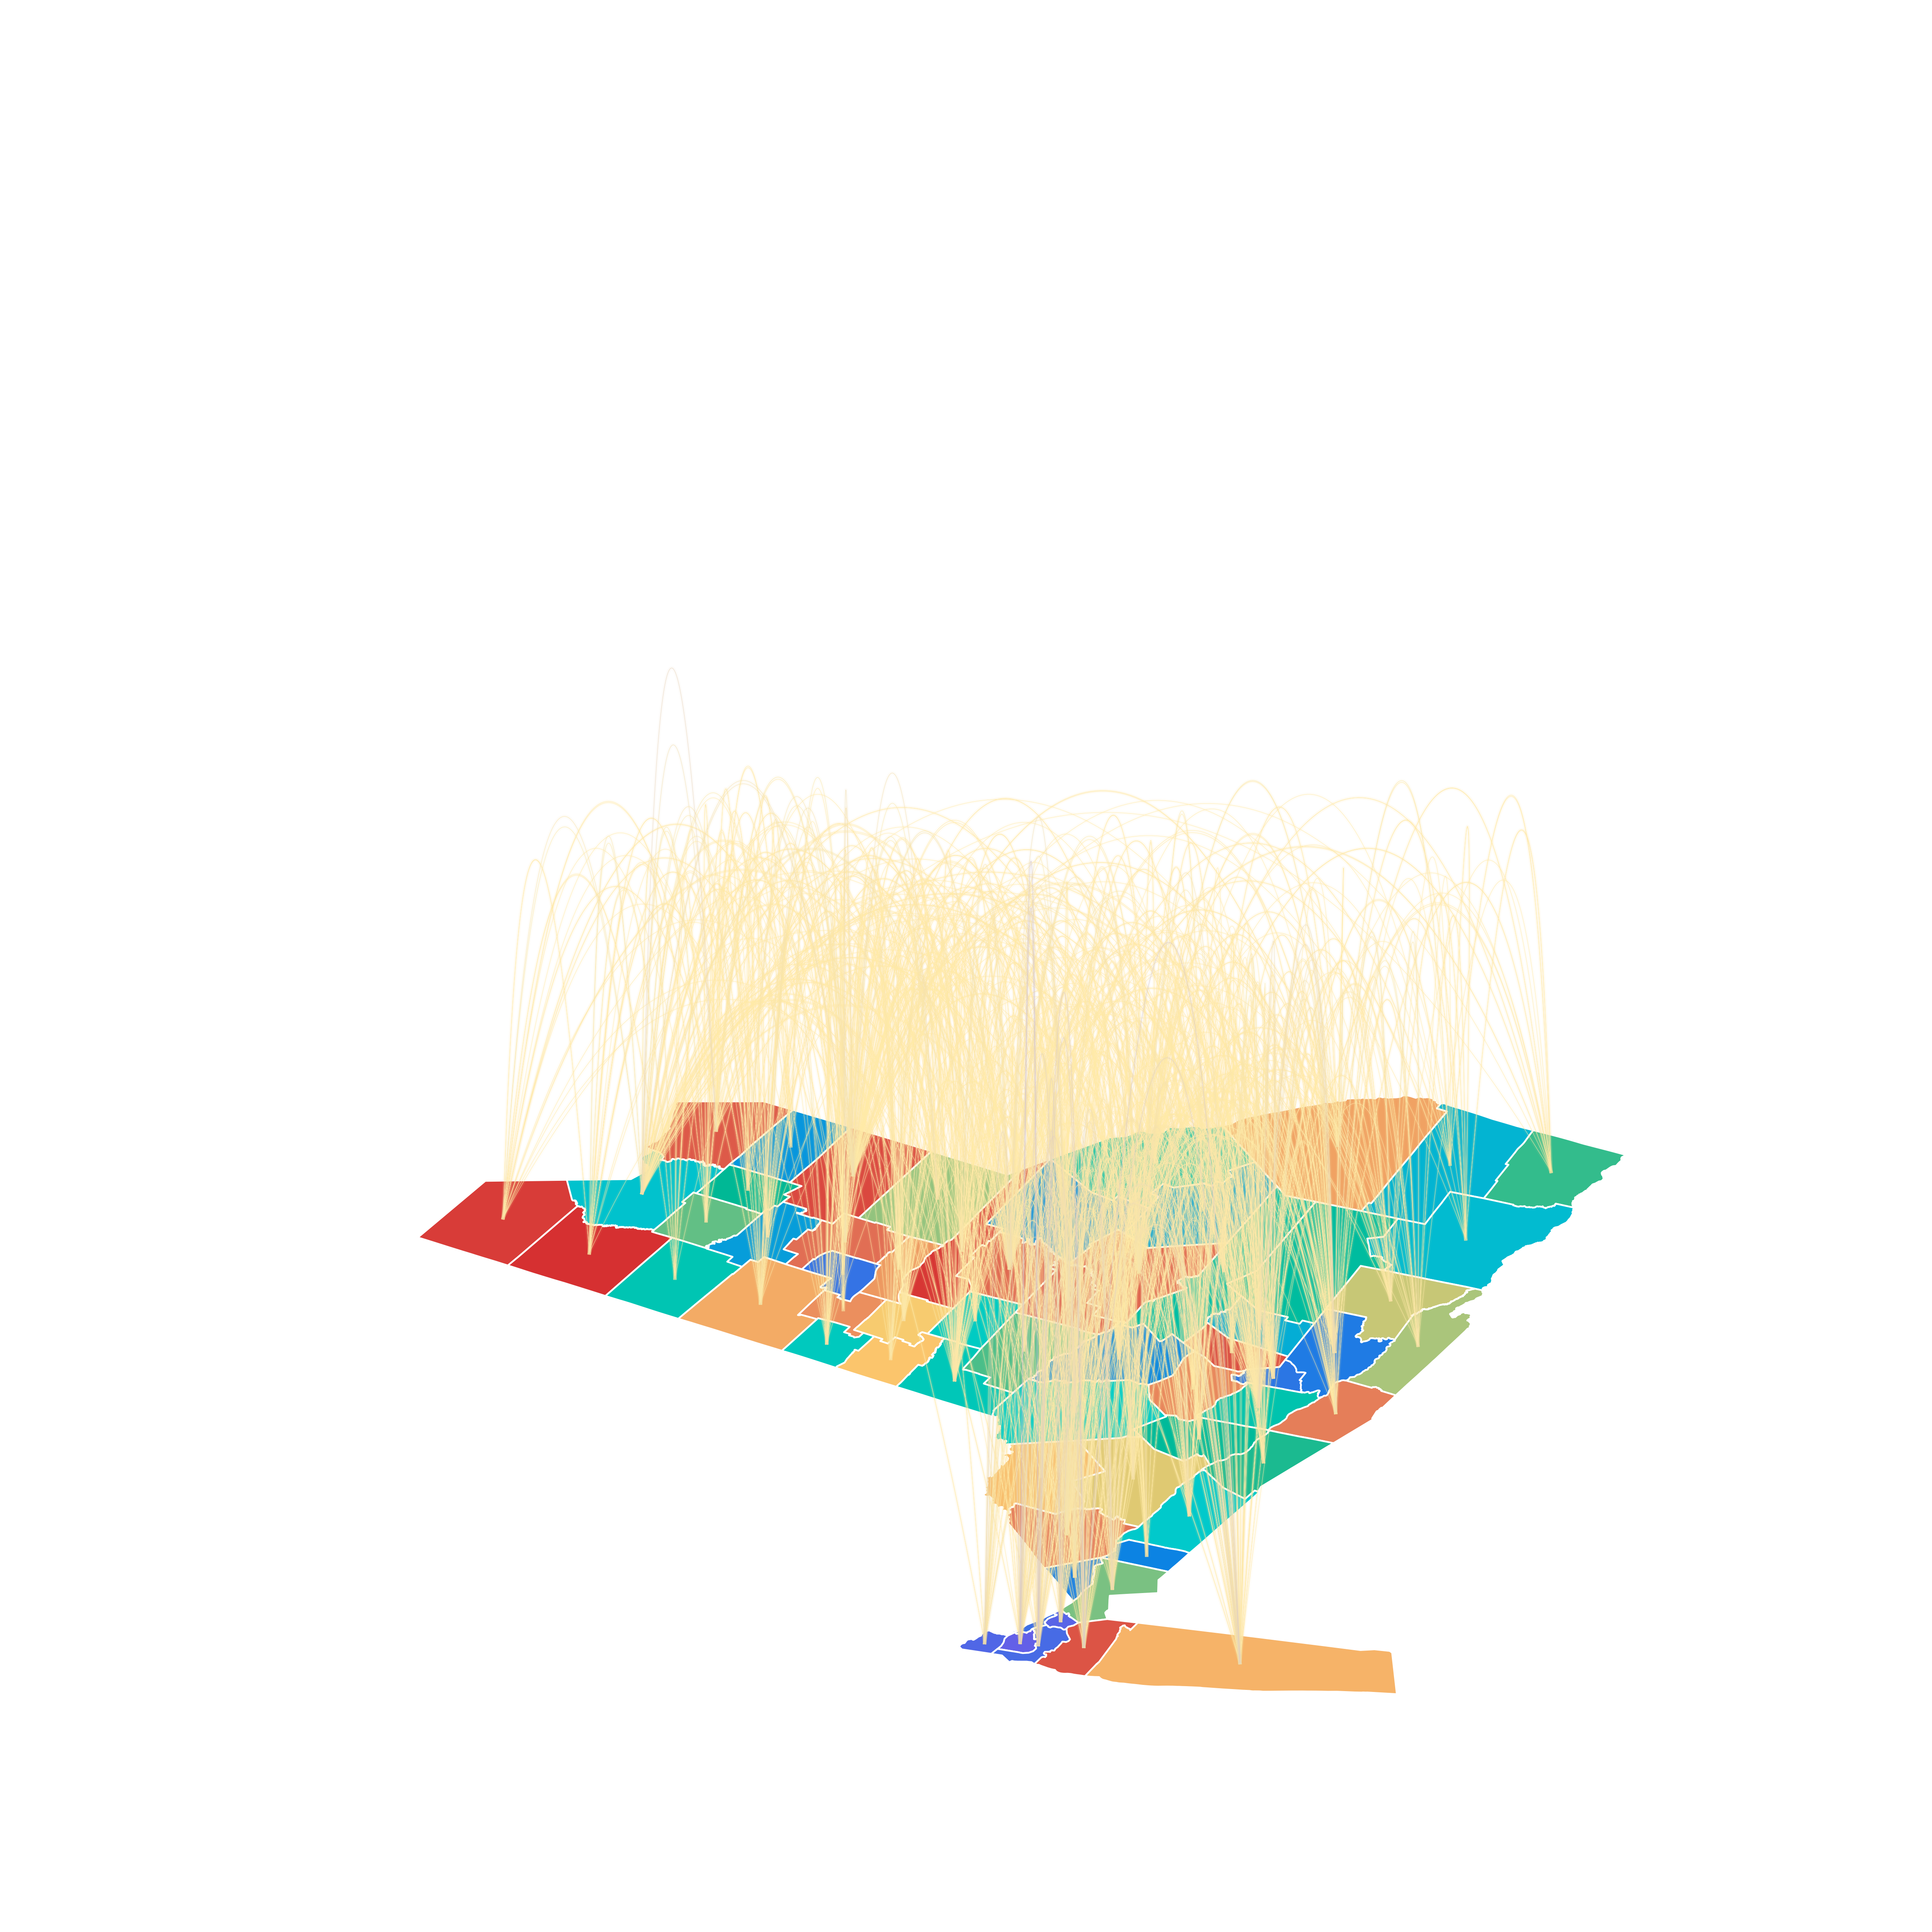

In [10]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap, Normalize
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

data = df_sparse.copy()

# 下载美国州界数据
gdf = gpd.read_file('../data/epidemic/kx-new-york-state-counties-SHP.zip')
gdf['NAME'] = gdf['NAME'].str.replace('St Lawrence', 'St. Lawrence')

fig = plt.figure(figsize=(12, 8), dpi=600)
ax = fig.add_subplot(111, projection='3d')

# 绘制 OD 线路
center_dict = {row['NAME']:row['geometry'].centroid.coords[0] for _, row in gdf.iterrows()}
myhot = LinearSegmentedColormap.from_list('myhot', ['#ffeaa7', '#a29bfe'], gamma=0.6)
norm = Normalize(vmin=0, vmax=data['flow'].max())
for idx, row in tqdm(data.iterrows(), total=len(data), desc='Drawing OD Flow'):
    if row['source'] not in center_dict or row['destination'] not in center_dict: 
        print(row['source'], row['destination'])
        continue
    x1, y1 = center_dict[row['source']]
    x2, y2 = center_dict[row['destination']]
    height = 0.1 * (row['flow'] + 0.3 * data['flow'].max())  # 根据流量设置高度，可以调整比例
    t = np.linspace(0, 1, num=100)
    x = x1 + (x2 - x1) * t
    y = y1 + (y2 - y1) * t
    z = height * 4 * t * (1 - t)  # 抛物线方程
    ax.plot(x, y, z, color=myhot(norm(row['flow'])), linewidth=1.0, zorder=10000+row['flow'], alpha=0.08)
    ax.plot(x, y, z, color=myhot(norm(row['flow'])), linewidth=0.1, zorder=10000+row['flow'], alpha=1.0)

ax.set_xlim(*ax.get_xlim()) # fix aspect ratio
ax.set_ylim(*ax.get_ylim())

# 绘制区域
myhsv = LinearSegmentedColormap.from_list('myhsv', ['#d63031', '#e17055', '#fdcb6e', '#00b894', '#00cec9', '#0984e3', '#6c5ce7'])
norm = Normalize(vmin=0, vmax=len(gdf))
for idx, row in tqdm(gdf.iterrows(), total=len(gdf), desc='Drawing MODZCTA Boundaries'):
    if row['geometry'].geom_type == 'Polygon':
        x, y = row['geometry'].exterior.xy
        poly_collection = Poly3DCollection([list(zip(x, y, [0]*len(x)))], color=myhsv(norm(idx)), zorder=10, linewidth=0.5, edgecolor='white')
        ax.add_collection3d(poly_collection)
    elif row['geometry'].geom_type == 'MultiPolygon':
        for polygon in row['geometry'].geoms:
            x, y = polygon.exterior.xy
            poly_collection = Poly3DCollection([list(zip(x, y, [0]*len(x)))], color=myhsv(norm(idx)), zorder=10, linewidth=0.5, edgecolor='white')
            ax.add_collection3d(poly_collection)

# 设置视角和标签
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# ax.set_title('OD Flow')
ax.axis('off')

# X = np.linspace(*ax.get_xlim(), 10)
# Y = np.linspace(*ax.get_ylim(), 10)
# X, Y = np.meshgrid(X, Y)
# Z = np.zeros_like(X)
# ax.plot_surface(X, Y, Z, zorder=0, color='#000034', alpha=0.1)

# ax.set_facecolor('lightblue')
fig.tight_layout()

plt.show()

# 保存数据

In [11]:
import json

node2idx = {n:idx for idx, n in enumerate(node)}
df_sparse['source_idx'] = df_sparse['source'].map(node2idx)
df_sparse['destination_idx'] = df_sparse['destination'].map(node2idx)
G = df_sparse[['source_idx', 'destination_idx']].values
A = np.zeros((len(node), len(node),), dtype=int)
A[G[:, 0], G[:, 1]] = 1

save = {}
save['node'] = node.tolist() # (N=62,)
save['time'] = time.tolist() # (T=1142,)
save['case'] = case.tolist() # (T=1142, N=62)
save['flow'] = df_sparse['flow'].tolist() # (E=1240,)
save['A'] = A.tolist() # (N=62, N=62)
save['G'] = G.tolist() # (E=1240, 2)
with open('../data/epidemic/COVID19inNYS.json', 'w') as f:
    json.dump(save, f)

for key, value in save.items():
    print(f'{key:10} -> {np.array(value).shape}')

node       -> (62,)
time       -> (163,)
case       -> (163, 62)
flow       -> (1240,)
A          -> (62, 62)
G          -> (1240, 2)
